In [53]:
# Initializing


import pandas as pd 

import numpy as np 


%matplotlib inline

import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()

sns.set_style("darkgrid")

# ignore sklearn & seaborn warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 


from scipy import stats
from scipy.stats import norm, skew  #ex. sns(fit = norm)


# Format scientific notation from pandas aggregation
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [54]:
df_dummies = pd.read_csv('data/csv_versions/version5/all_data.csv')
df_no_dummies = pd.read_csv('data/csv_versions/version5/all_data_no_dummies.csv') 

In [55]:
targets = pd.read_csv('data/y_train.csv') 

In [56]:
from sklearn.model_selection import GridSearchCV, train_test_split 

from sklearn import linear_model as lm 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 

from sklearn.metrics import mean_squared_error  

#rms error: 
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))   

### Split all_data into train and test (for Kaggle submission): 

In [57]:
ntrain = targets.shape[0] 
x_d = df_dummies[:ntrain]
x_d_kag_test = df_dummies[ntrain:]
x_nd = df_no_dummies[:ntrain]
x_nd_kag_test = df_no_dummies[ntrain:]
targets_log = targets.apply(np.log)


In [58]:
x_d_kag_test.shape

(1459, 221)

### Drop dominant feature columns for dummified categorical variables in x_d dataset: 

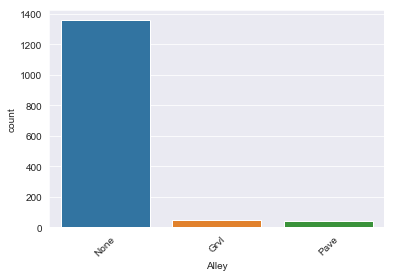

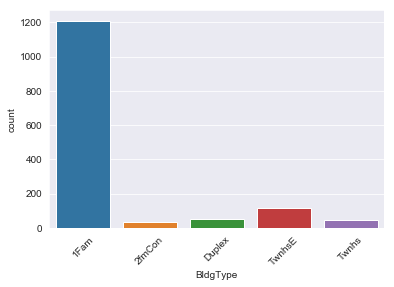

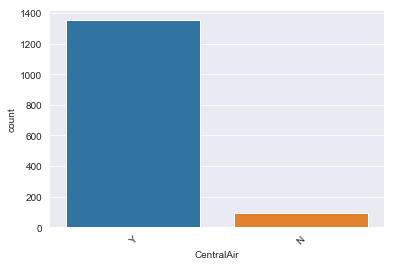

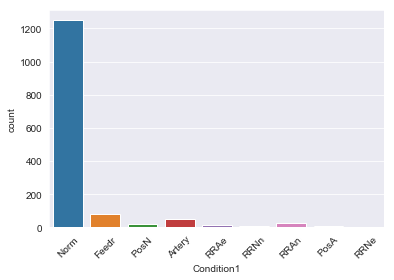

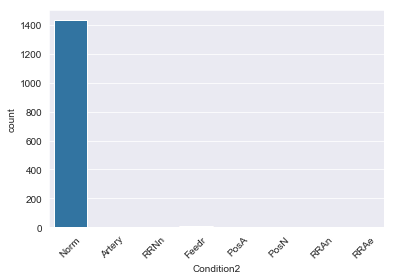

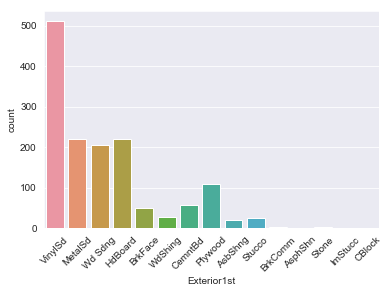

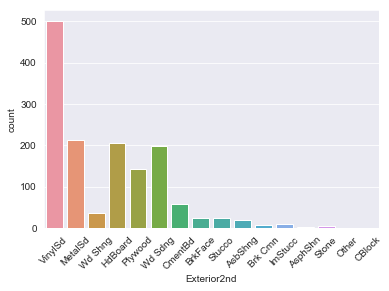

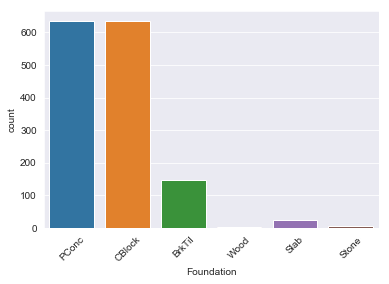

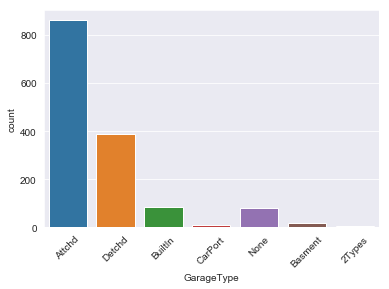

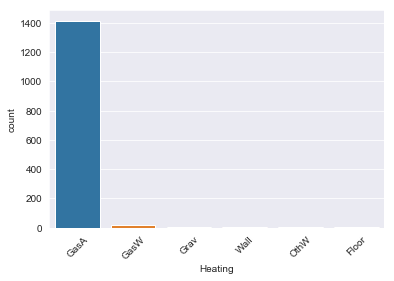

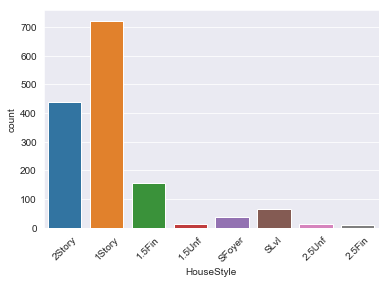

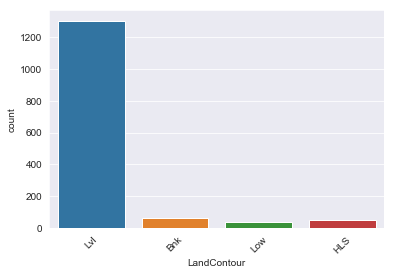

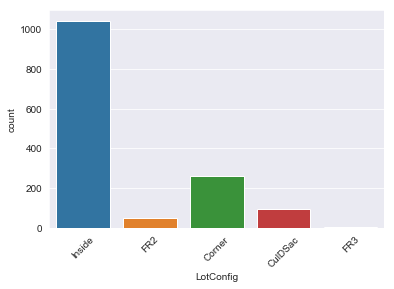

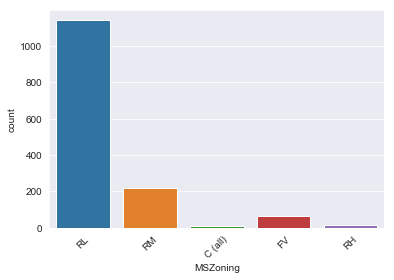

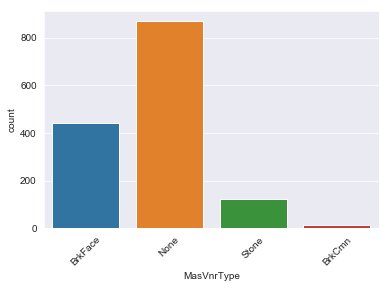

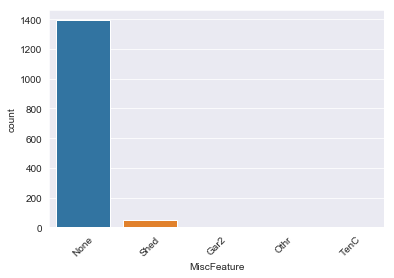

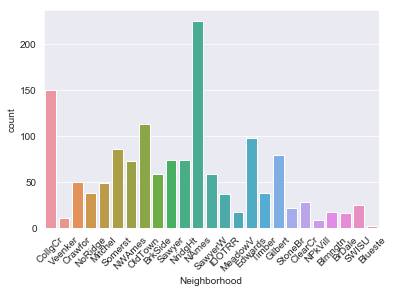

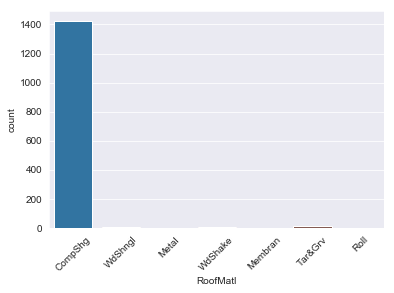

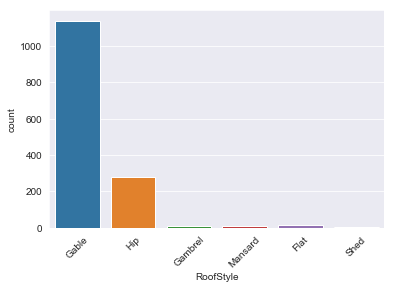

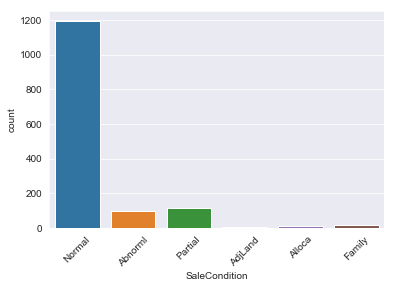

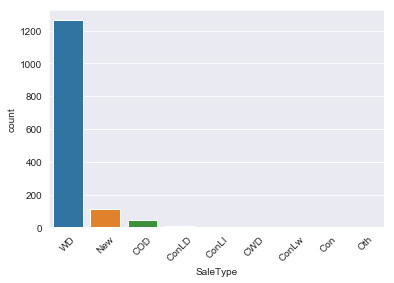

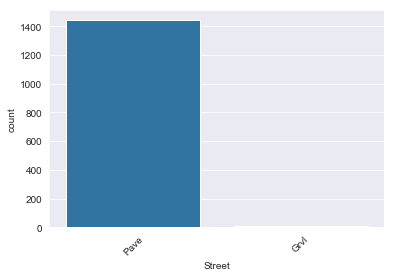

In [59]:
for i, col in enumerate(x_nd.select_dtypes(['object']).columns):
    plt.figure(i)
    ax = sns.countplot(x = col, data = x_nd)
    plt.xticks(rotation=45)
    plt.show()  

In [60]:
#drop dominant columns for dummified variables 

x_d_dom_drop = x_d.drop(['Alley_None', 'Condition1_Norm', 'Condition2_Norm','Exterior1st_VinylSd', 'Exterior1st_VinylSd', 'Foundation_CBlock', 'GarageType_Attchd', 'Heating_GasA', 'HouseStyle_1Story', 'LandContour_Lvl', 'LotConfig_Inside', 'MasVnrType_None', 'MiscFeature_None','MSZoning_RL', 'Neighborhood_NAmes', 'RoofMatl_CompShg', 'RoofStyle_Gable', 'SaleCondition_Normal', 'SaleType_WD', 'Street_Pave'], axis = 1)  

In [61]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
scaler.fit(x_d_dom_drop)
x_d_std = scaler.transform(x_d_dom_drop)

x_d_std = pd.DataFrame(x_d_std) 


In [63]:
x_d_kag_dom_drop = x_d_kag_test.drop(['Alley_None', 'Condition1_Norm', 'Condition2_Norm','Exterior1st_VinylSd', 'Exterior1st_VinylSd', 'Foundation_CBlock', 'GarageType_Attchd', 'Heating_GasA', 'HouseStyle_1Story', 'LandContour_Lvl', 'LotConfig_Inside', 'MasVnrType_None', 'MiscFeature_None','MSZoning_RL', 'Neighborhood_NAmes', 'RoofMatl_CompShg', 'RoofStyle_Gable', 'SaleCondition_Normal', 'SaleType_WD', 'Street_Pave'], axis = 1)

In [64]:
scaler.fit(x_d_kag_dom_drop)
x_d_kag_std = scaler.transform(x_d_kag_dom_drop)

x_d_kag_std = pd.DataFrame(x_d_kag_std)  

### Split x_d_std and targets into train and test using train_test_split: 

In [65]:
x_d_train, x_d_test, y_d_train, y_d_test = train_test_split(x_d_std, targets_log, test_size = 0.2, random_state = 42) 


## MODELLING

### 1. Multiple Linear Regression: 

In [66]:
lm_model =lm.LinearRegression()
lm_model.fit(x_d_train, y_d_train)

#RMS error 
print("RMSE train: {}".format(rmse(y_d_train, lm_model.predict(x_d_train)))) 
print("RMSE test : {}".format(rmse(y_d_test,  lm_model.predict(x_d_test)))) 
print('R^2 score: {}'.format(lm_model.score(x_d_train, y_d_train)))




RMSE train: 0.08713142549532918
RMSE test : 0.13707320159190486
R^2 score: 0.9497482446336774


### 2. Ridge/Lasso/Elastic Net : Penalised LR 

In [67]:
#1. ridge: 

grid_param = [{'alpha': np.linspace(1e-3,1,50)}]

gs = GridSearchCV(estimator=lm.Ridge(random_state=42), param_grid=grid_param, cv=5)

gs.fit(x_d_std, targets_log)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_d_train, model.predict(x_d_train))))
print("RMSE test : {}".format(rmse(y_d_test,  model.predict(x_d_test))))
print('R^2 score: {}'.format(model.score(x_d_train, y_d_train)))  

Best params: {'alpha': 1.0}
Best score : 0.8957966229751597
RMSE train: 0.09022147636902639
RMSE test : 0.11354076247285998
R^2 score: 0.9461207604565011


In [68]:
x_d_kag_std.shape 

(1459, 202)

### Kaggle Test Submission 1: Predict on test set using Ridge regression

In [69]:
y_pred_ridge = model.predict(x_d_kag_std)  
y_pred_ridge = pd.DataFrame(y_pred_ridge) 
y_pred_ridge[0] = y_pred_ridge[0].apply(lambda x: np.exp(x)) 
y_pred_ridge = y_pred_ridge.reset_index() 
y_pred_ridge.columns = ['Id', 'SalePrice']
y_pred_ridge['Id'] = y_pred_ridge['Id'].apply(lambda x: x + 1461) 
y_pred_ridge.set_index('Id', inplace = True)
y_pred_ridge.to_csv('data/kaggle_ridge_submission6.csv') #0.12545 

In [44]:
#2. Lasso: 

grid_param = [{'alpha': np.linspace(1e-4,1,20)}] 

gs = GridSearchCV(estimator=lm.Lasso(random_state= 42, normalize=False), param_grid=grid_param, cv=5)

gs.fit(x_d_std, targets_log)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_d_train, model.predict(x_d_train))))
print("RMSE test : {}".format(rmse(y_d_test,  model.predict(x_d_test)))) 


Best params: {'alpha': 0.0001}
Best score : 0.8989008788759423
RMSE train: 0.09154006938676919
RMSE test : 0.1132295610231453


In [19]:
model.fit(x_d_std, targets_log)
print('The intercept is %.4f' %(model.intercept_))
lassoCoef = pd.Series(model.coef_, index=x_d_std.columns)
print('The slopes are \n%s' %(lassoCoef))  

The intercept is 12.0156
The slopes are 
0      0.026
1      0.025
2      0.000
3      0.002
4      0.003
5     -0.005
6      0.029
7      0.004
8     -0.006
9     -0.000
10     0.010
11    -0.001
12    -0.012
13    -0.000
14    -0.002
15     0.000
16     0.015
17     0.008
18    -0.002
19     0.003
20    -0.001
21     0.014
22     0.007
23     0.018
24     0.018
25     0.013
26     0.001
27    -0.002
28     0.001
29     0.000
       ...  
121   -0.002
122   -0.011
123    0.006
124    0.006
125    0.004
126    0.021
127   -0.006
128    0.004
129   -0.018
130   -0.022
131   -0.003
132    0.000
133   -0.004
134    0.004
135    0.016
136   -0.016
137    0.001
138    0.002
139    0.001
140    0.014
141    0.014
142    0.005
143    0.005
144    0.005
145    0.004
146    0.000
147   -0.000
148   -0.000
149    0.006
150   -0.008
Length: 151, dtype: float64


In [45]:
#3: Elastic Net 

grid_param = [{'alpha': np.linspace(1e-4,1e-2,20), 'l1_ratio': np.linspace(0.015, 1, 20)}]

# Confirmed that setting scoring='neg_mean_squared_error' is the same result as using the default "R2" score.
gs = GridSearchCV(estimator=lm.ElasticNet(random_state=42), param_grid=grid_param, cv=5)

gs.fit(x_d_std, targets_log) 

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_)) 
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_d_train, model.predict(x_d_train))))
print("RMSE test : {}".format(rmse(y_d_test, model.predict(x_d_test))))  

Best params: {'alpha': 0.01, 'l1_ratio': 0.3778947368421052}
Best score : 0.9160419685833884
RMSE train: 0.09699616855381053
RMSE test : 0.12216060430480652


In [46]:
#proportion of coeffs > 1e-6 out of all coeffs 

sum(model.coef_ > 1e-6) / model.coef_.shape[0]   

0.23711340206185566

Preparation for tree-based models: encode nominal categorical variables in x_nd df: 

In [111]:
x_nd.columns

Index(['Unnamed: 0', 'ExterQual', 'Exterior1st', 'Fireplaces', 'Foundation', 'GarageArea', 'GrLivArea', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LotShape', 'Neighborhood', 'OverallQual', 'TotRmsAbvGrd', 'Num_Bathrooms', 'HouseSF', 'YearRemodAgg'], dtype='object')

In [119]:
from sklearn.preprocessing import LabelEncoder

['Alley_None', 'Exterior1st_VinylSd', 'Foundation_CBlock', 'GarageType_Attchd',  'HouseStyle_1Story', 'MasVnrType_None', 'MiscFeature_None','Neighborhood_NAmes'], axis = 1)  

In [132]:
#use LabelEncode to encode categorical vars 

lencoder = LabelEncoder()

alley_labels = lencoder.fit_transform(x_nd.Alley).reshape((-1,1))
exterior1st_labels  =lencoder.fit_transform(x_nd.Exterior1st).reshape((-1,1))
foundation_labels = lencoder.fit_transform(x_nd.Foundation).reshape((-1,1))  
garagetype_labels = lencoder.fit_transform(x_nd.GarageType).reshape((-1,1))
housestyle_labels    = lencoder.fit_transform(x_nd.HouseStyle).reshape((-1,1))
lotshape_labels   = lencoder.fit_transform(x_nd.LotShape).reshape((-1,1))
masvnrtype_labels = lencoder.fit_transform(x_nd.MasVnrType).reshape((-1,1))
miscfeature_labels = lencoder.fit_transform(x_nd.MiscFeature).reshape((-1,1))
neighborhood_labels= lencoder.fit_transform(x_nd.Neighborhood).reshape((-1,1)) 

x_nd_le = [alley_labels, exterior1st_labels, foundation_labels, garagetype_labels, housestyle_labels, lotshape_labels, masvnrtype_labels, miscfeature_labels, neighborhood_labels] 

In [133]:
#create list numerical + encoded nominal categorical features 

num_cols = x_nd.select_dtypes(exclude = ['object']).columns 

for col in num_cols: 
    x_nd_le.append(x_nd[col].reshape((-1, 1))) 


In [134]:
x_nd_le

[array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]), array([[12],
        [ 8],
        [12],
        ...,
        [ 5],
        [ 8],
        [ 6]]), array([[2],
        [1],
        [2],
        ...,
        [4],
        [1],
        [1]]), array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]), array([[5],
        [2],
        [5],
        ...,
        [5],
        [2],
        [2]]), array([[  0],
        [477],
        [478],
        ...,
        [966],
        [967],
        [968]]), array([[1],
        [2],
        [1],
        ...,
        [2],
        [2],
        [2]]), array([[1],
        [1],
        [1],
        ...,
        [3],
        [1],
        [1]]), array([[ 5],
        [24],
        [ 5],
        ...,
        [ 6],
        [12],
        [ 7]]), array([[4],
        [4],
        [4],
        ...,
        [1],
        [4],
        [4]]), array([[3],
        [1],
        [2],
        ...,
    

In [156]:
#concatenate features (including encoded nominal categorical variables)-> new dataframe 


x_nd_le = pd.DataFrame(x_nd_le)  
x_nd_le.shape

x_nd_le.columns = ['alley', 'exterior1st', 'foundation', 'garagetype', 'housestyle', 'lotshape', 'masvnrtype', 'miscfeature', 'neighborhood'] + list(num_cols)  

In [157]:
x_nd_le.head()

,alley,exterior1st,foundation,garagetype,housestyle,lotshape,masvnrtype,miscfeature,neighborhood,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtUnfSF,ExterQual,Fence,FireplaceQu,Fireplaces,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HeatingQC,HouseSF,KitchenQual,LotArea,LotFrontage,LotShape,MiscVal,Num_Bathrooms,OpenPorchSF,OverallQual,PoolArea,PoolQC,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearRemodAgg
0,1.000,12.000,2.000,1.000,5.000,0.000,1.000,1.000,5.000,4.000,3.000,706.000,2.000,6.000,2.000,150.000,2.000,4.000,3.000,0.000,548.000,2.000,5.000,2.000,5.000,2003.000,1710.000,0.000,3114.000,2.000,8450.000,65.000,0.000,0.000,3.500,61.000,6.000,0.000,3.000,0.000,8.000,856.000,0.000,2003.000
1,1.000,8.000,1.000,1.000,2.000,477.000,2.000,1.000,24.000,4.000,1.000,978.000,0.000,6.000,2.000,284.000,3.000,4.000,5.000,1.000,460.000,2.000,5.000,2.000,5.000,1976.000,1262.000,0.000,2984.000,3.000,9600.000,80.000,1931.000,0.000,2.500,0.000,5.000,0.000,3.000,0.000,6.000,1262.000,298.000,1976.000
2,1.000,12.000,2.000,1.000,5.000,478.000,1.000,1.000,5.000,4.000,2.000,486.000,2.000,6.000,2.000,434.000,2.000,4.000,5.000,1.000,608.000,2.000,5.000,2.000,5.000,2001.000,1786.000,0.000,3314.000,2.000,11250.000,68.000,1932.000,0.000,3.500,42.000,6.000,0.000,3.000,0.000,6.000,920.000,0.000,2001.500
3,1.000,13.000,0.000,5.000,5.000,479.000,2.000,1.000,6.000,1.000,3.000,216.000,0.000,6.000,4.000,540.000,3.000,4.000,2.000,1.000,642.000,3.000,5.000,3.000,5.000,1998.000,1717.000,2.000,3115.000,2.000,9550.000,60.000,1933.000,0.000,2.000,35.000,6.000,0.000,3.000,0.000,7.000,756.000,0.000,1942.500
4,1.000,12.000,2.000,1.000,5.000,480.000,1.000,1.000,15.000,4.000,0.000,655.000,2.000,6.000,2.000,490.000,2.000,4.000,5.000,1.000,836.000,3.000,5.000,2.000,5.000,2000.000,2198.000,0.000,4179.000,2.000,14260.000,84.000,1934.000,0.000,3.500,84.000,7.000,0.000,3.000,0.000,9.000,1145.000,192.000,2000.000


In [159]:
#train_test split of non-dummified dataframe 

x_nd_train, x_nd_test, y_nd_train, y_nd_test = train_test_split(x_nd_le, targets_log, test_size = 0.2, random_state = 42)  


### 3. Random Forest 

In [120]:

#test random forest regressor with default parameters: 

randomForest = RandomForestRegressor()

# fit RF model on training set
randomForest.set_params(random_state=42)

randomForest.fit(x_nd_train, y_nd_train)  

print("The training error is: %.5f" % (1- randomForest.score(x_nd_train, y_nd_train))) 
print("The test     error is: %.5f" % (1 - randomForest.score(x_nd_test, y_nd_test)))   

The training error is: 0.04859
The test     error is: 0.28646


In [121]:
grid_para_forest = {
    'n_estimators': range(80, 200, 10),
    'max_depth': range(3,12),
    'max_features': ['sqrt', 'auto']
}  

In [122]:
gs = GridSearchCV(estimator = RandomForestRegressor(\
                                    min_samples_split=5,\
                                    #max_depth = 10,\
                                    min_samples_leaf=1,\
                                    random_state=42,\
                                    n_jobs=-1),\
                  param_grid = grid_para_forest, n_jobs=-1, cv=5)   

In [123]:
gs.fit(x_nd_train, y_nd_train)  

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=5,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(3, 12),
          

In [298]:
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))   

Best params: {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 90}
Best score : 0.7694308012689799


In [124]:
forest_final = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_d_train, forest_final.predict(x_nd_train)))) #0.1044
print("RMSE test : {}".format(rmse(y_d_test,  forest_final.predict(x_nd_test)))) #0.1962  

RMSE train: 0.1370776203002676
RMSE test : 0.19620686829323788


In [125]:

forest_feature_importance = forest_final.feature_importances_

forest_sorted_features = sorted(list(zip(x_nd_le.columns, forest_feature_importance)), key = lambda kv: kv[1], reverse = True) 

forest_sorted_features 

[('housesf', 0.4007116462865751),
 ('overallqual', 0.2153847488979508),
 ('year_remod_agg', 0.14127826204855218),
 ('kitchenqual', 0.11586024082597046),
 ('num_bathrooms', 0.08905445677203017),
 ('neighborhood', 0.03771064516892126)]

Text(0.5,1,'Feature Importance: Random Forest')

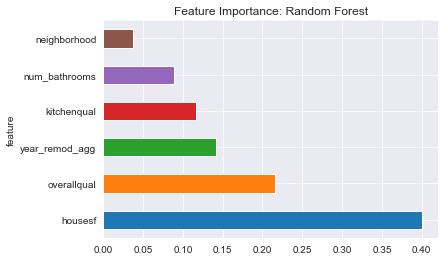

In [126]:
#graph feature importances of top 25 features 

a, b = zip(*forest_sorted_features)
importance_score = pd.DataFrame({'feature':a, 'score':b})
importance_score.plot.barh(x='feature', y='score', legend=None)
plt.title('Feature Importance: Random Forest')

### 4. GBM

In [160]:
gbm = GradientBoostingRegressor()  

In [161]:
gbm_1 = gbm.fit(x_nd_train, y_nd_train) 

print("The training error is: %.5f" % (1- gbm.score(x_nd_train, y_nd_train))) 
print("The test     error is: %.5f" % (1 - gbm.score(x_nd_test, y_nd_test)))   

The training error is: 0.04486
The test     error is: 0.16254


In [162]:
from sklearn.metrics import r2_score 
n_estimators = 50100
steps = range(100, 50100, 1000)

gbm.set_params(learning_rate = 1, n_estimators=n_estimators, max_depth=3)
gbm.fit(x_nd_train, y_nd_train)
gen = gbm.staged_predict(x_nd_train)
r2_rate1 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_rate1.append(r2_score(predicted_targets, y_nd_train))    

In [186]:
from sklearn.metrics import r2_score 
n_estimators = 50100
steps = range(100, 50100, 1000)

gbm.set_params(learning_rate = 0.1, n_estimators=n_estimators, max_depth=3)
gbm.fit(x_nd_train, y_nd_train)
gen = gbm.staged_predict(x_nd_train)
r2_rate01 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_rate01.append(r2_score(predicted_targets, y_nd_train))    

In [130]:
from sklearn.metrics import r2_score 
n_estimators = 50100
steps = range(100, 50100, 1000)

gbm.set_params(learning_rate = 0.01, n_estimators=n_estimators, max_depth=3)
gbm.fit(x_nd_train, y_nd_train)
gen = gbm.staged_predict(x_nd_train)
r2_rate001 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_rate001.append(r2_score(predicted_targets, y_nd_train))    

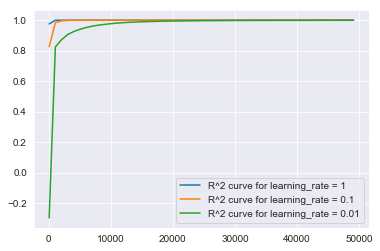

In [188]:
plt.plot(steps, r2_rate1,  label=r'R^2 curve for learning_rate = 1')
plt.plot(steps, r2_rate01, label=r'R^2 curve for learning_rate = 0.1')
plt.plot(steps, r2_rate001, label=r'R^2 curve for learning_rate = 0.01')
plt.legend(loc=4) 

In [163]:
n_estimators = 3000
gbm.set_params(learning_rate=0.005, max_depth=5, max_features = 'sqrt', subsample = 0.9,  n_estimators=n_estimators, min_samples_split=7,
min_samples_leaf=10)

train_r2 = []
test_r2  = []
steps = range(100, 3000, 100)

gbm.fit(x_nd_train,y_nd_train)
gen_train = gbm.staged_predict(x_nd_train) #generators 
gen_test  = gbm.staged_predict(x_nd_test)

for n in range(n_estimators):
           predicted_train = next(gen_train)
           predicted_test  = next(gen_test)
           if n not in steps: continue
           train_r2.append(r2_score(predicted_train, y_nd_train))
           test_r2.append(r2_score(predicted_test, y_nd_test))        

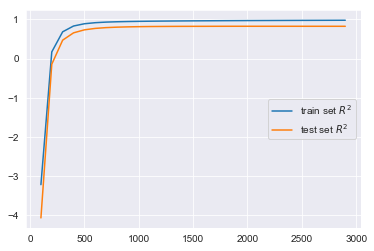

In [164]:
plt.plot(steps, train_r2, label='train set $R^2$')
plt.plot(steps, test_r2, label='test set $R^2$')
plt.legend(loc=7) 

In [165]:
print(max(train_r2),max(test_r2))

0.9771652735301178 0.8234946740125555


In [166]:
print("RMSE train: {}".format(rmse(y_nd_train, gbm.predict(x_nd_train))))
print("RMSE test : {}".format(rmse(y_nd_test,  gbm.predict(x_nd_test)))) 

RMSE train: 0.05612131846281633
RMSE test : 0.14816586777211746


In [167]:
gbm_feature_importance = gbm.feature_importances_

gbm_sorted_features = sorted(list(zip(x_nd_le.columns, gbm_feature_importance)), key = lambda kv: kv[1], reverse = True) 

gbm_sorted_features 

[('HouseSF', 0.16584702844887406),
 ('OverallQual', 0.1278866390432387),
 ('GrLivArea', 0.10303728598077834),
 ('YearRemodAgg', 0.08184529646065339),
 ('Num_Bathrooms', 0.06539863334068673),
 ('GarageCars', 0.06352393899122707),
 ('ExterQual', 0.03972571318243926),
 ('TotalBsmtSF', 0.03826170541526372),
 ('GarageArea', 0.03688626424981316),
 ('KitchenQual', 0.027341398255800564),
 ('Fireplaces', 0.027008866026645394),
 ('garagetype', 0.026215949677309097),
 ('GarageYrBlt', 0.02507527816287693),
 ('LotArea', 0.023744351010769143),
 ('BsmtFinSF1', 0.020184377756091113),
 ('BsmtQual', 0.01609024341658191),
 ('TotRmsAbvGrd', 0.011639137893282935),
 ('LotFrontage', 0.009900711134617044),
 ('neighborhood', 0.00846979075114872),
 ('OpenPorchSF', 0.008312219875467932),
 ('HeatingQC', 0.0080448059134478),
 ('BsmtUnfSF', 0.007416106393345893),
 ('GarageFinish', 0.006823002937245283),
 ('foundation', 0.00661599863335808),
 ('WoodDeckSF', 0.005742130657718649),
 ('BsmtFinType1', 0.0046247055257129

In [304]:
grid_para_gbm = {
    'max_depth': range(3,10),
    'max_features': ['sqrt', 'auto'], 
    'min_samples_split':range(3,21,3), 
    'min_samples_leaf': np.arange(1,10,1),
    'subsample':[0.6,0.7,0.75,0.8,0.85,0.9], 
    'learning_rate': [0.005, 0.01, 0.05, 0.1]   
}  

In [305]:
gs = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 500), param_grid = grid_para_gbm, n_jobs = -1, cv = 5)   

In [306]:
gs.fit(x_nd_train, y_nd_train) 

KeyboardInterrupt: 

In [ ]:
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_nd_train, model.predict(x_nd_train))))
print("RMSE test : {}".format(rmse(y_nd_test,  model.predict(x_nd_test))))

### 5. SVR

In [168]:
from sklearn.svm import SVR 

In [169]:
svr = SVR()
svr.set_params(kernel='rbf') 

paramDict = {'C': np.linspace(1, 100, 20), 'gamma': np.linspace(1e-4, 1e-2, 10)}
svr_grid = GridSearchCV(svr, paramDict, cv=5, return_train_score = True)
svr_grid.fit(x_d_train, y_d_train) 



KeyboardInterrupt: 

In [329]:
svr_grid.best_params_ 
svr_grid.best_score_

0.4215911969172941

In [330]:
svr_best = svr_grid.best_estimator_
svr_best.fit(x_d_train,y_d_train)
svr_best.score(x_d_train, y_d_train)

0.8974298508940413

In [331]:
print("RMSE train: {}".format(rmse(y_d_train, svr_best.predict(x_d_train))))
print("RMSE test : {}".format(rmse(y_d_test, svr_best.predict(x_d_test))))

RMSE train: 0.12379148817191436
RMSE test : 0.2949315596484075


### 6. Stacking: 

### Stack base models: 

In [49]:
from mlxtend.regressor import StackingRegressor




In [48]:
models = [
    # linear model
 
    #lm.ElasticNet(alpha = 0.01, l1_ratio = 0.32605263157894737, random_state=42),
    
    lm.Ridge(alpha = 0.01, random_state = 42), 
 
     #conservative random forest model
    RandomForestRegressor(\
                        max_depth=5,\
                        max_features='sqrt',\
                        n_estimators=1000,\
                        random_state=42,\
                        n_jobs=-1),
    
#     RandomForestRegressor(\
#                         max_features= 8,\
#                         n_estimators=200,\
#                         min_samples_split=5,\
#                         min_samples_leaf=1,\
#                         random_state= 42,\
#                         n_jobs=-1),
#     RandomForestRegressor(\
#                         max_depth=None,\
#                         max_features=8,\
#                         n_estimators=170,\
#                         random_state=42,\
#                         n_jobs=-1),
    
    #conservative gbm model
    GradientBoostingRegressor(\
                        learning_rate=0.005,\
                        n_estimators=3000,\
                        max_depth=2,\
                        min_samples_split=40,\
                        min_samples_leaf=10,\
                        max_features= 'sqrt',\
                        subsample=0.8,\
                        random_state=42),
    
#     GradientBoostingRegressor(\
#                         learning_rate=0.005,\
#                         n_estimators=3000,\
#                         max_depth=5,\
#                         min_samples_split=7,\
#                         min_samples_leaf=1,\
#                         max_features='sqrt',\
#                         subsample=0.8,\
#                         random_state= 42)
    
#     GradientBoostingRegressor(\
#                         learning_rate=0.01,\
#                         n_estimators=2000,\
#                         max_depth=5,\
#                         min_samples_split=28,\
#                         min_samples_leaf=3,\
#                         max_features=63,\
#                         subsample=0.8,\
#                         random_state=rs_const)
    ]

meta_model = lm.LinearRegression(normalize=False) 

In [50]:
stack_reg = StackingRegressor(regressors= models, 
                           meta_regressor=meta_model)  

In [51]:

stack_reg.fit(x_d_train, y_d_train)
stack_reg.predict(x_d_train)    

array([[11.66382245],
       [11.71210884],
       [11.95675862],
       ...,
       [12.17179012],
       [12.44309312],
       [12.05920123]])

In [52]:
print("RMSE train: {}".format(rmse(y_d_train, stack_reg.predict(x_d_train))))
print("RMSE test: {}".format(rmse(y_d_test, stack_reg.predict(x_d_test)))) 

# train: 0.113
#test: 0.14606 

RMSE train: 0.08481775421788827
RMSE test: 0.1333148538757671


In [48]:
y_pred_stack = stack_reg.predict(x_d_kag_std)  
y_pred_stack = pd.DataFrame(y_pred_stack) 
y_pred_stack[0] = y_pred_stack[0].apply(lambda x: np.exp(x)) 
y_pred_stack = y_pred_stack.reset_index() 
y_pred_stack.columns = ['Id', 'SalePrice']
y_pred_stack['Id'] = y_pred_stack['Id'].apply(lambda x: x + 1461) 
y_pred_stack.set_index('Id', inplace = True)
y_pred_stack.to_csv('data/kaggle_ridge_submission2.csv') 